# 3D Cloud TOA Notebook
This notebook allows the user to perform inference on cloud content in ABI data. 

ABI data is loaded from disk, and a 128x128 chip is created from user-defined lat, lon input. Users can either input one single lat/lon pair, which will be the center of the generated image, or 2 "endpoints". In the case of endpoints, the center of the image will be the midpoint of both inputs. *See the "user-defined values" cell for example usage.*

The generated image (128x128 pixel "chip") will then be generated, processed, and be fed into the model. Finally, the image and the transect used will be plotted alongside the model output, a predicted cloud mask at varying altitudes.  

## Installs/imports

In [1]:
# !pip install pyhdf netcdf4 h5netcdf rioxarray torchgeo

In [2]:
# !pip install torchgeo

In [3]:
import pyhdf
from pyhdf.SD import SD, SDC

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys 
import torch
from matplotlib import colormaps

from generate_chip import (load_abi, gather_files, get_L1B_L2, create_chip, 
                           plot_rgb_chip_and_mask)

sys.path.append('satvision-toa')
from satvision_toa.configs.config import _C, _update_config_from_file
from satvision_toa.datasets.abi_3dcloud_dataset import AbiToa3DCloudDataset
from threedcloud_svtoa import (ABITransform, load_pretrained_model, FCN, 
                              MinMaxEmissiveScaleReflectance, reverse_transform)

/home/ajkerr1/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## User-defined values

In [4]:
# Time of day, year, day of year
t = 15 # 15, 16, 17, 19
YYYY = "2019"
DDD = "270"

# Root directory for all ABI data, path to NetCDF ABI file
ROOT = "/explore/nobackup/people/jli30/data/abi_dg/abi/"
abi_path = "/explore/nobackup/people/jgong/ABI_EAST_GEO_TOPO_LOMSK.nc"

def midpoint (p1, p2):
    return (p1[0]+p2[0])/2, (p1[1]+p2[1])/2

# ----------------------------------------
# Input 2 endpoints p1, p2 or a single point to generate chip 
# (single point is center of chip). Generated endpoint must be
# within the bounds: 
#    lat: [-39.5, 39.5]
#    lon: [-122.5, -26.25]
# ----------------------------------------

p1 = (20, -50)
p2 = (25, -45)
lat, lon = midpoint(p1, p2)
print(f'lat, lon midpoint used to generate chip: {lat, lon}')

lat, lon midpoint used to generate chip: (22.5, -47.5)


## Read, process ABI data

In [5]:
abi_dict = load_abi(abi_path)

## Create chip

In [6]:
chip, coords = create_chip(abi_dict, t, YYYY, DDD, lat, lon, ROOT)

Loading Data


In [7]:
def generate_transect_latlon(lat, lon):
    lat_list = generate_transect_single_coord(
        lat, 'lat')
    lon_list = generate_transect_single_coord(
        lon, 'lon')
    
    return lat_list, lon_list

def generate_transect_single_coord(coord, coord_type):
    coord_list = np.zeros(91)
    coord_list[45] = coord
    
    DELTA_LAT = -0.009673
    DELTA_LON = 0.002268
    
    if (coord_type == 'lat'):
        delta = DELTA_LAT
    else:
        delta = DELTA_LON
    
    for i in range(45):
        lower_val = coord - (delta * (45 - i))
        upper_val = coord + (delta * (i + 1))
        coord_list[i] = lower_val
        coord_list[i+46] = upper_val
        
    return coord_list

## Load model

#### Filenames and directories

In [8]:
model_dir = './3B_26M/'
config_filename = model_dir + 'mim_pretrain_swinv2_satvision_giant_128_window08_patch8_onecycle_100ep.yaml'
model_filename = model_dir + 'mp_rank_00_model_states.pt'

#### Load config file

Required for loading pretrained SatVision model. 

In [9]:
config = _C.clone()
_update_config_from_file(config, config_filename)
config.defrost()
config.MODEL.RESUME = model_filename
config.OUTPUT = '.'
config.freeze();

=> merge config from ./3B_26M/mim_pretrain_swinv2_satvision_giant_128_window08_patch8_onecycle_100ep.yaml


#### Build base model

This will be our base transformer model with SatVision embeddings. This model has not been trained on cloud masking, but will be matched to this task below. 

In [10]:
OUTPUT_CHANNELS = 1
freeze_encoder = False
pretrained_model = load_pretrained_model(config)
model = FCN(swin_encoder=pretrained_model.encoder, num_output_channels=OUTPUT_CHANNELS, freeze_encoder=freeze_encoder)
model.eval()
model.cuda();

/home/ajkerr1/.local/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Load checkpoint for 3D cloud task

Model that has been built from config is the general SatVision model, this model will be untrained on the cloud masking task. By loading this checkpoint, we are allowing the model to specialize to this downstream task.

In [11]:
checkpoint_filename = os.path.join(
    '/explore/nobackup/projects/ilab/projects',
    'SatVision/SatVision-TOA/3DClouds/models/3DCLOUD-TASK',
    'svtoa-checkpoints/3B_26M/epoch=41-val_iou=0.54145294.ckpt.ckpt',
    'checkpoint/mp_rank_00_model_states.pt')
checkpoint = torch.load(checkpoint_filename)
checkpoint_model = checkpoint['module']
checkpoint_model = {k.replace('model.', ''): v for k, v in checkpoint_model.items() if k.startswith('model')}
model.load_state_dict(checkpoint_model, strict=False);

## Perform Model Inference

In [12]:
logit = model(chip)
pred = torch.sigmoid(logit)

## Viz

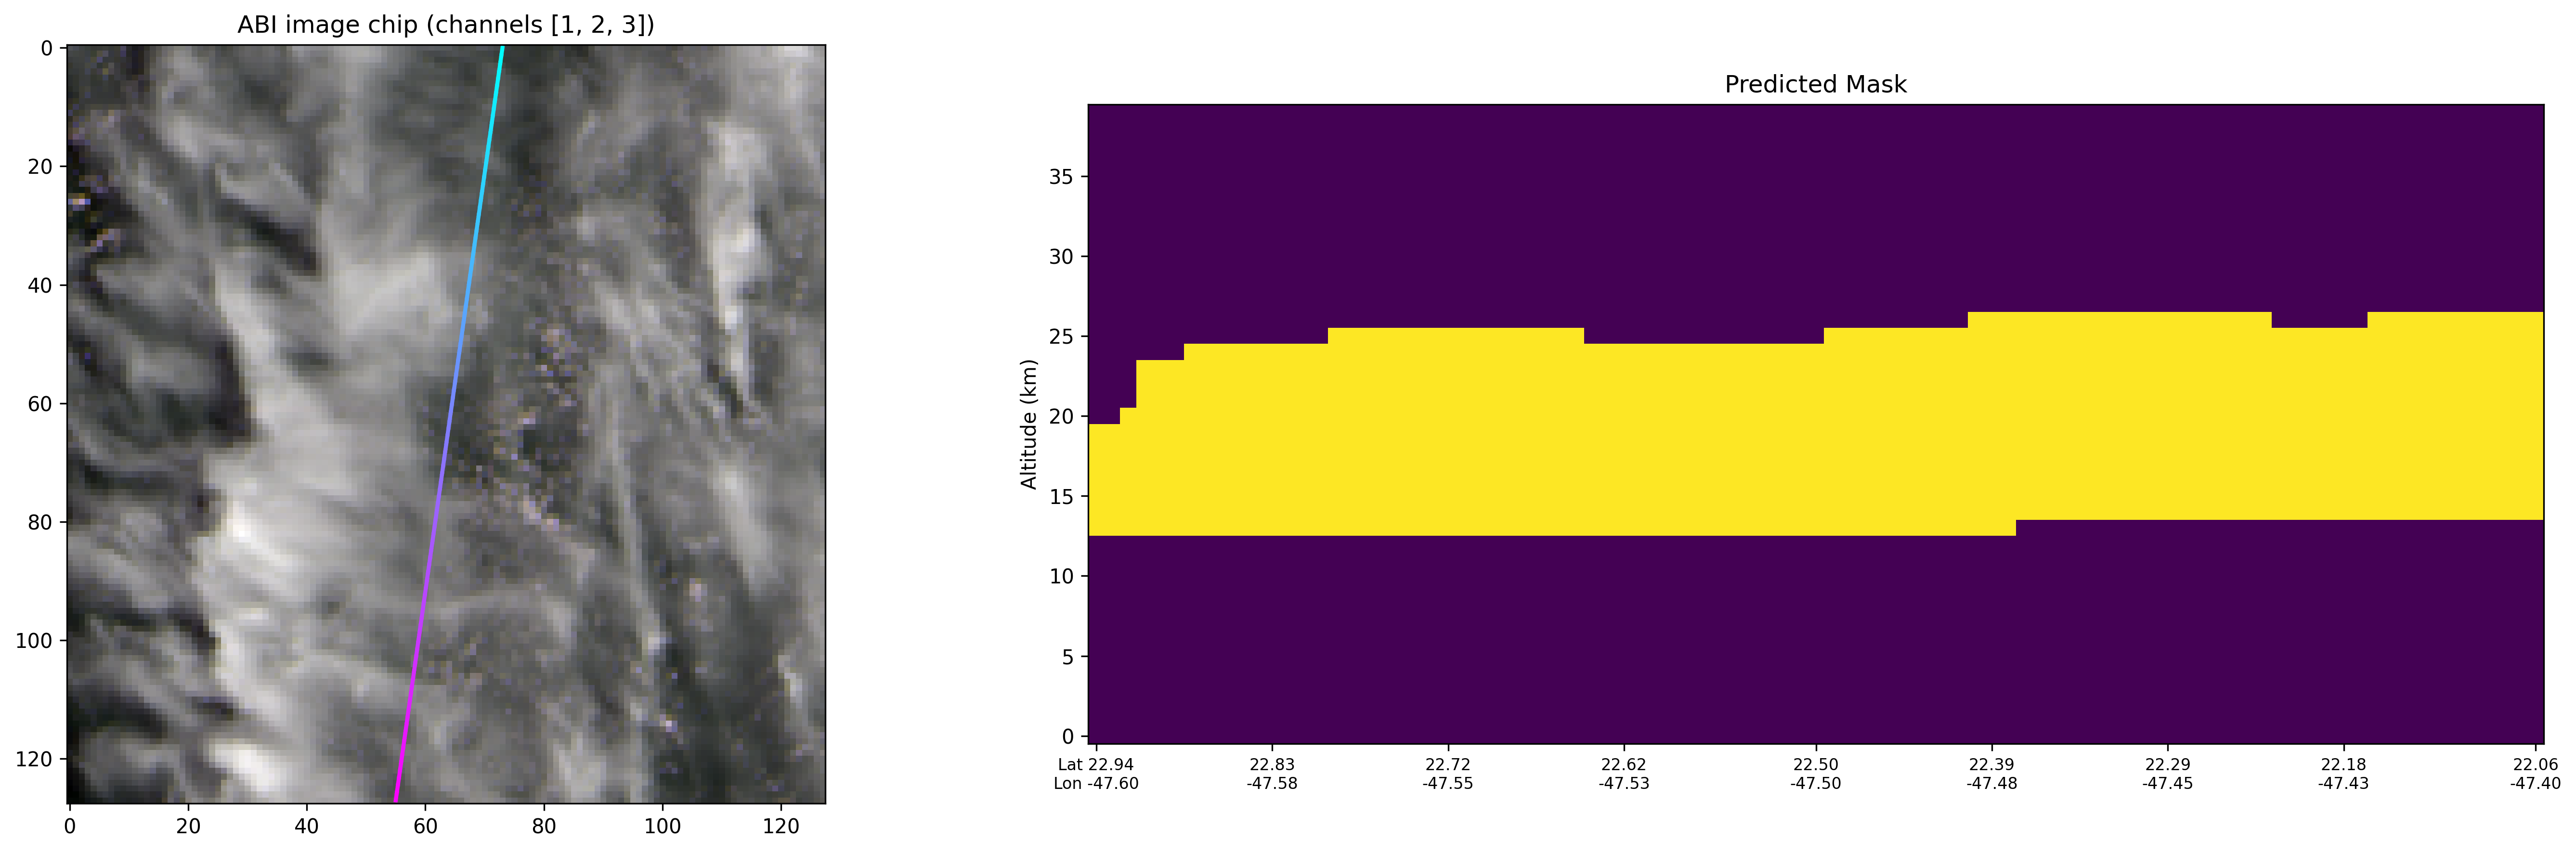

In [13]:
plot_rgb_chip_and_mask(chip, pred, lat, lon)